# Signal-to-noise ratio estimate

In [1]:
import pandas as pd
import os, glob, shutil
import soundfile as sf

## Read label tracks

In [2]:
def to_pd(csv_path, ext="txt", add_duration=False):
    df = pd.read_csv(csv_path, sep='\t').drop(columns=['index'])
    df[['type', 'loudness']] = df['label'].str.split('-', n=1, expand=True)
    df['inter'] = df.apply(lambda l: pd.Interval(l.start, l.end), axis=1)
    if add_duration:
        wave_file = csv_path.replace(ext, "wav")
        full_inter = pd.DataFrame(data={'inter': [pd.Interval(0, sf.info(wave_file).duration)],
                                        'type': 'd'})
        df = pd.concat([df,full_inter],
                        ignore_index=True, copy=False)
    return df.drop(columns=['label', 'start', 'end'])

In [3]:
def dir_to_pd(dir_path, ext="clean.txt", add_duration=False):
    farm_df = None
    for f in glob.glob(f"*.{ext}", root_dir=dir_path):
        df = to_pd(os.path.join(dir_path, f), add_duration=add_duration)
        #print(df)
        df['origin'] = f[:-len(ext)-1]
        if farm_df is None:
            farm_df = df
        else:
            farm_df = pd.concat([farm_df, df], ignore_index=True, copy=False)
    return farm_df


In [4]:
def drop_overlapping(df: pd.DataFrame, inplace=False):
    df = df[df['type'] != 'd']
    to_del = []
    for file in pd.unique(df['origin']):
        fdf = df[df['origin'] == file]
        for i in fdf.index:
            if True in pd.arrays.IntervalArray(fdf['inter'].drop(i)).overlaps(fdf.loc[i, 'inter']):
                to_del.append(i)
    return df.drop(to_del, inplace=inplace)

In [39]:
def gen_bg(df : pd.DataFrame):
    df.sort_values(by=['origin','inter'], inplace=True)
    res_df = None
    for origin in pd.unique(df['origin']):
        fdf = df[df['origin'] == origin]
        row_dur = fdf[fdf['type'] == 'd']
        fdf = fdf[fdf['type'] != 'd']
        if len(row_dur) != 1:
            raise Exception(f"Could not find duration for file {origin}")
        duration = row_dur.iloc[0].inter.right
        bg_inter = []
        start = 0
        for i, r in fdf.iterrows():
            if start < r.inter.left:
                bg_inter.append(pd.Interval(start, r.inter.left))
            start = r.inter.right
        if start < duration:
            bg_inter.append(pd.Interval(start, duration))
        bg_df = pd.DataFrame(data={
            'type': len(bg_inter) * ['bg'],
            'loudness': len(bg_inter) * [None],
            'origin': len(bg_inter) * [origin],
            'inter': bg_inter
        })
        if res_df is None:
            res_df = bg_df
        else:
            res_df = pd.concat([res_df, bg_df], ignore_index=True, copy=False)
    return res_df

### Fake data

In [50]:
df = pd.DataFrame(data={
    'start': [1,5,9.3, 1.5],
    'end': [2,5.1,11, 3],
    'label': ['h-h', 'pn-s', 'l-s', 'n-l']
})
df.to_csv(os.path.join(manuals, "f7.clean.txt"), index=False)
df = pd.DataFrame(data={
    'start': [10,5.6,9.5],
    'end': [12,7,10],
    'label': ['h-l', 'n-s', 'l-s']
})
df.to_csv(os.path.join(manuals, "f3.clean.txt"), index=False)
shutil.copy("/home/poulpos/data/pigs/short_for_predic/BOX1-FARMEIK/calls-0000.wav", os.path.join(manuals, "f7.wav"))
shutil.copy("/home/poulpos/data/pigs/short_for_predic/BOX1-FARMEIK/calls-1345.wav", os.path.join(manuals, "f3.wav"))

<module 'os' from '/home/poulpos/.pyenv/versions/3.10.10/lib/python3.10/os.py'>

In [49]:
manuals = "/tmp/manuals"

In [97]:
dir_to_pd(manuals, "clean.txt", add_duration=True)

type loudness                      inter          file
0    h        l               (10.0, 12.0]  f3.clean.txt
1    n        s                 (5.6, 7.0]  f3.clean.txt
2    l        s                (9.5, 10.0]  f3.clean.txt
3    d      NaN  (0.0, 16.109569160997733]  f3.clean.txt
4    h        h                 (1.0, 2.0]  f7.clean.txt
5   pn        s                 (5.0, 5.1]  f7.clean.txt
6    l        s                (9.3, 11.0]  f7.clean.txt
7    n        l                 (1.5, 3.0]  f7.clean.txt
8    d      NaN   (0.0, 27.06122448979592]  f7.clean.txt

In [99]:
drop_overlapping(dir_to_pd(manuals, "clean.txt", add_duration=True))

type loudness         inter          file
0    h        l  (10.0, 12.0]  f3.clean.txt
1    n        s    (5.6, 7.0]  f3.clean.txt
2    l        s   (9.5, 10.0]  f3.clean.txt
5   pn        s    (5.0, 5.1]  f7.clean.txt
6    l        s   (9.3, 11.0]  f7.clean.txt

In [104]:
gen_bg(dir_to_pd(manuals, "clean.txt", add_duration=False))

Exception: Could not find duration for file f3.clean.txt

### Real data

In [117]:
ground_label = "/run/media/poulpos/PIGS-KU-BU1/cleaned/BOX3-FARMHE2/manuals"
l = dir_to_pd(ground_label, "txt", add_duration=True)

In [118]:
l

index type loudness                     inter  \
0     1.0    l        l      (1.118264, 3.030136]   
1     2.0    l        l       (3.156391, 4.97808]   
2     3.0    l        l       (4.97808, 6.024198]   
3     4.0    l        l       (6.601367, 7.82785]   
4     5.0    h        s       (7.82785, 9.433101]   
..    ...  ...      ...                       ...   
72   36.0    l        l    (21.979969, 22.324665]   
73   37.0    n        s    (22.575353, 23.014057]   
74   38.0    l        l    (24.648006, 24.907647]   
75   39.0    l        l    (25.279202, 25.646281]   
76    NaN    d      NaN  (0.0, 28.04124716553288]   

                                                file  
0   manual~BOX3-FARMHE2_20230809_173000~manual~1.txt  
1   manual~BOX3-FARMHE2_20230809_173000~manual~1.txt  
2   manual~BOX3-FARMHE2_20230809_173000~manual~1.txt  
3   manual~BOX3-FARMHE2_20230809_173000~manual~1.txt  
4   manual~BOX3-FARMHE2_20230809_173000~manual~1.txt  
..                                               ...  
72  manual~BOX3-FARMHE2_20230815_100000~manual~1.txt  
73  manual~BOX3-FARMHE2_20230815_100000~manual~1.txt  
74  manual~BOX3-FARMHE2_20230815_100000~manual~1.txt  
75  manual~BOX3-FARMHE2_20230815_100000~manual~1.txt  
76  manual~BOX3-FARMHE2_20230815_100000~manual~1.txt  

[77 rows x 5 columns]

## Compute spectro sum

In [6]:
import sys
prediction_src_path = '/home/poulpos/pigs-documentary/as-fork/ANIMAL-SPOT'
sys.path.insert(1, prediction_src_path)

In [8]:
from vis.spec import ClippedAudioDataset
import numpy as np

In [ ]:
ground_label = "/run/media/poulpos/PIGS-KU-BU1/cleaned/BOX2-FARMOTT/manuals"
l = dir_to_pd(ground_label, "txt", add_duration=True)
clean_label = pd.concat([drop_overlapping(l), gen_bg(l)])
clean_label =  clean_label[clean_label.apply(lambda r: r.inter.length > 1024/44100, axis=1)]
cad = ClippedAudioDataset(clean_label, working_dir=ground_label)
all = pd.concat([l for l in cad], axis=1).T
all = all.astype({'type': 'str', 'sum':'float'})

/home/poulpos/.pyenv/versions/3.10.10/envs/pigs/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 9 rows containing non-finite values.


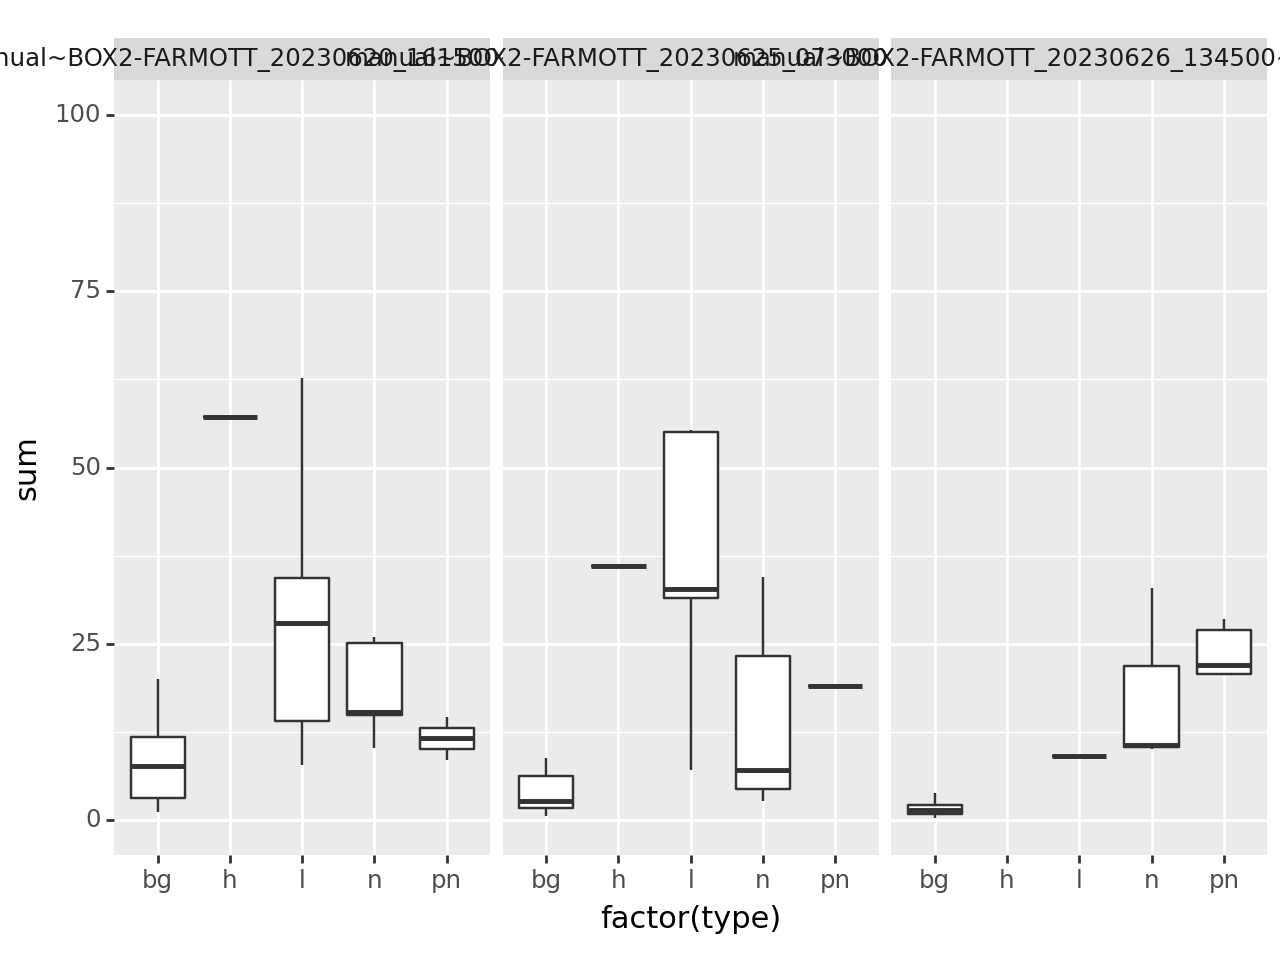

<Figure Size: (640 x 480)>

In [174]:
from plotnine import ggplot, geom_boxplot, aes, ylim, facet_wrap
ggplot(all[['type', 'sum', "origin"]], aes(x="factor(type)", y="sum")) + geom_boxplot(notch=False, outlier_shape="") + facet_wrap("~origin", ncol=3) + ylim(0, 100)

In [179]:
from plotnine import geom_violin
exclude = .2
pt = {'h': None, 'l': None}
for c in pt:
    light = all.drop(columns=['loudness', 'inter'])
    lf = light[light['type'] == c].drop(columns=['type']).rename({'sum': 'sum_c'},axis=1)
    bg = light[light['type'] == 'bg'].drop(columns=['type']).rename({'sum': 'sum_bg'},axis=1)
    cross = pd.merge(lf, bg)
    cross['dummy'] = 0
    cross['snr'] = 10*np.log10(cross['sum_c']/cross['sum_bg'] - 1)
    print(f"Call {c}")
    print(cross['snr'].quantile(q=exclude))
    print(cross['snr'].quantile(q=1-exclude))
    pt[c] = ggplot(cross, aes(x="dummy", y='snr')) + geom_violin()

Call h
7.107582654268151
15.648741286012461
Call l
3.0381167804839193
18.97299622114926


/home/poulpos/.pyenv/versions/3.10.10/envs/pigs/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
/home/poulpos/.pyenv/versions/3.10.10/envs/pigs/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10


/home/poulpos/.pyenv/versions/3.10.10/envs/pigs/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 1 rows containing non-finite values.


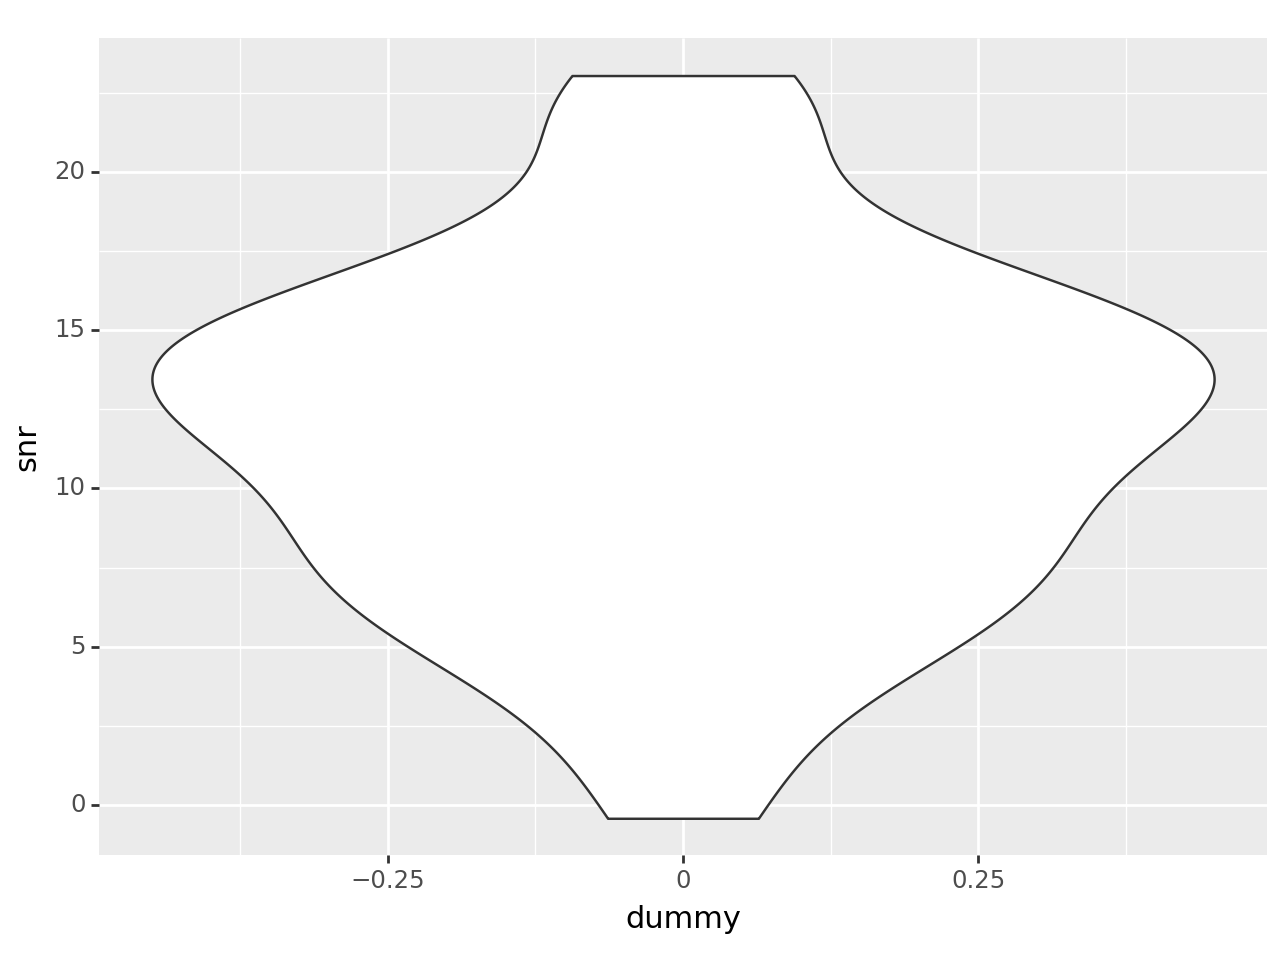

/home/poulpos/.pyenv/versions/3.10.10/envs/pigs/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 31 rows containing non-finite values.


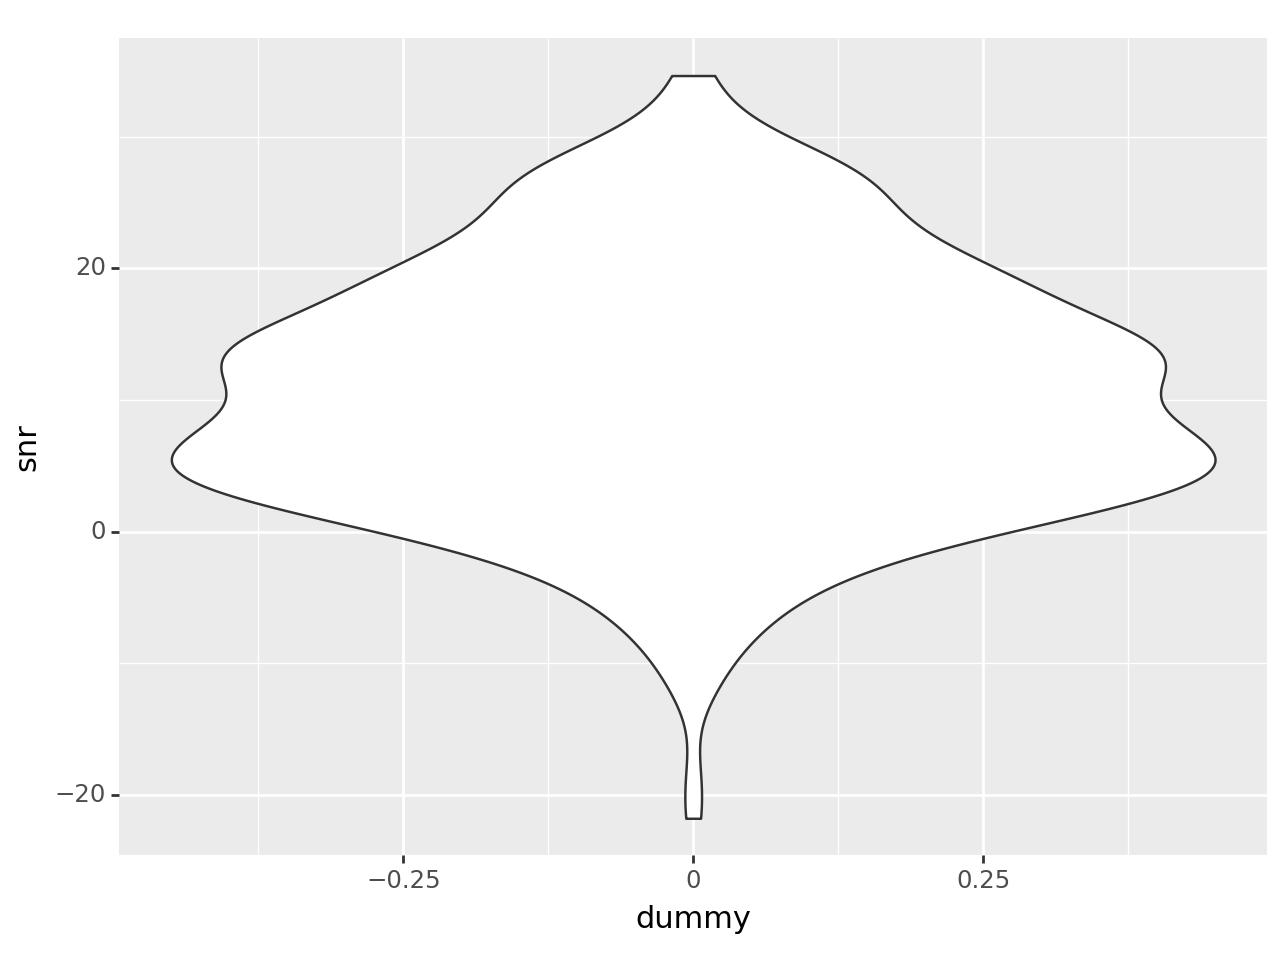

In [182]:
for c,v in pt.items():
    print(v)